# CE888 Assignment 1 (21a2): Inexperienced Queries

##  Import packages

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, LSTM, Embedding, Dense

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc


## Load data

Replace the filepath with the complete path to where the file was downloaded.

In [2]:
df = pd.read_json(open("train_spider.json", "r", encoding="utf8"))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   db_id                7000 non-null   object
 1   query                7000 non-null   object
 2   query_toks           7000 non-null   object
 3   query_toks_no_value  7000 non-null   object
 4   question             7000 non-null   object
 5   question_toks        7000 non-null   object
 6   sql                  7000 non-null   object
dtypes: object(7)
memory usage: 382.9+ KB


In [3]:
df.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'from': {'table_units': [['table_unit', 1]], ..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'from': {'table_units': [['table_unit', 1]], ..."
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'from': {'table_units': [['table_unit', 0]], ..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'from': {'table_units': [['table_unit', 0]], ..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'from': {'table_units': [['table_unit', 0]], ..."


## Instances selection

1000 questions that query a numerical value (average, min, max, count, sum)  are going to be selected. This list of selected instances will have the presence of questions with different levels of difficulty. This level of difficulty will be determined based on the presence of SQL keywords are found in the target SQL query; in other words, how many `JOIN`, `GROUP BY`, `ORDER BY`, `INTERSECT`, etc... are found in each query.


In [4]:
total_avg = 0
total_min = 0
total_max = 0
total_count = 0
total_sum = 0
list_filtered = []
add_flag = False

for index, tokens in enumerate(df["query_toks"].values.tolist()):
    if ("avg" in tokens):
        add_flag = True
        total_avg += 1
    if ("min" in tokens):
        add_flag = True
        total_min += 1
    if ("max" in tokens):
        add_flag = True
        total_max += 1
    if ("count" in tokens):
        add_flag = True
        total_count += 1
    if ("sum" in tokens):
        add_flag = True
        total_sum += 1
    if add_flag:
        list_filtered.append(df.iloc[index])
    add_flag = False

print("avg: %d" % total_avg)
print("min: %d" % total_min)
print("max: %d" % total_max)
print("count: %d" % total_count)
print("sum: %d" % total_sum)

filtered_df_size = len(list_filtered)
print("Final size of filtered dataset: {}".format(filtered_df_size))
df_filtered = pd.DataFrame(list_filtered)


avg: 464
min: 165
max: 233
count: 1961
sum: 243
Final size of filtered dataset: 2836


In [5]:
data = [total_avg,total_min,total_max,total_count,total_sum]
index_names = ["total_avg","total_min","total_max","total_count","total_sum"]
keyword_df = pd.DataFrame(data, index=index_names, columns=["Keywords"])
keyword_df

,Keywords
total_avg,464
total_min,165
total_max,233
total_count,1961
total_sum,243


It was decided that given the recommendation of choosing approximately 1000 instances, count-related queries have been excluded of the filtered dataframe because it increased by a very large margin the size of the dataframe.

In [5]:
df_filtered.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'from': {'table_units': [['table_unit', 1]], ..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'from': {'table_units': [['table_unit', 0]], ..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'from': {'table_units': [['table_unit', 0]], ..."
7,department_management,SELECT born_state FROM head GROUP BY born_stat...,"[SELECT, born_state, FROM, head, GROUP, BY, bo...","[select, born_state, from, head, group, by, bo...",What are the names of the states where at leas...,"[What, are, the, names, of, the, states, where...","{'from': {'table_units': [['table_unit', 1]], ..."
8,department_management,SELECT creation FROM department GROUP BY creat...,"[SELECT, creation, FROM, department, GROUP, BY...","[select, creation, from, department, group, by...",In which year were most departments established?,"[In, which, year, were, most, departments, est...","{'from': {'table_units': [['table_unit', 0]], ..."


## Analyzing complexity of filtered dataset

In [6]:
print("Number of databases involved: " +
      str(len(df_filtered["db_id"].value_counts())))

Number of databases involved: 140


In [7]:
questions_lengths = df_filtered["query_toks"].apply(len)
max_q_len = np.max(questions_lengths)
print("Max length of questions: {}".format(max_q_len))
min_q_len = np.min(questions_lengths)
print("Min length of questions: {}".format(min_q_len))

Max length of questions: 60
Min length of questions: 7


A range from 7 to 60 tokens per query shows a sufficient variation in the difficulty of queries.

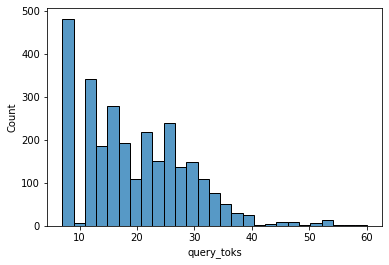

In [8]:
histogram = sns.histplot(questions_lengths)
fig = histogram.get_figure()
fig.savefig("query_length_distribution.png")

There is a heavy skewness to the left side in the distribution of the sizes of the queries. This means that there are fare more queries with small/medium size. Given that the model is meant for inexperienced people to be able to query databases, it is fair to assume that complex/large queries are not going to be as common a short ones.

C:\Python3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='query_toks'>

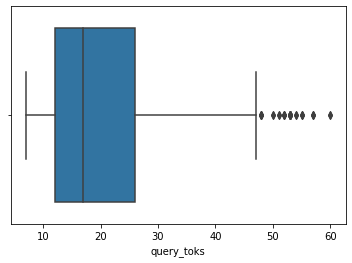

In [9]:
sns.boxplot(questions_lengths)

In [10]:
sql_keywords = ["add"," add constraint", "all", "alter", "alter column", 
                "alter table", "and", "any", "as", "asc", "backup database", 
                "between", "case", "check", "column", "constraint", "create", 
                "create database", "create index", "create or replace view", 
                "create table", "create procedure", "create unique index", 
                "create view", "database", "default", "delete", "desc", 
                "distinct", "drop", "drop column", "drop constraint", 
                "drop database", "drop default", "drop index", "drop table", 
                "drop view", "exec", "exists", "foreign key", "from", 
                "full outer join", "group by", "having", "in", "index", 
                "inner join", "insert into", "insert into select", "is null", 
                "is not null", "join left", "join", "like", "limit", "not", 
                "not null", "or", "order by", "outer join", "primary key", 
                "procedure", "right join", "rownum", "select", 
                "select distinct", "select into", "select top", "set", "table",
                "top", "truncate table", "union", "union all", "unique", 
                "update", "values", "view", "where"]

list_sum_keywords = []
sum = 0
for query in df_filtered["query_toks_no_value"]:
    for token in query:
        if token in sql_keywords:
            sum += 1
    list_sum_keywords.append(sum)
    sum = 0

print("Average number of keywords per query: \t %f" % 
      np.mean(list_sum_keywords))
print("Min number of keywords per query: \t %d" % np.min(list_sum_keywords))
print("Max number of keywords per query: \t %d" % np.max(list_sum_keywords))

Average number of keywords per query: 	 4.764104
Min number of keywords per query: 	 2
Max number of keywords per query: 	 16


The SQL queries contain an average of a little bit under 5 keywords per training example.

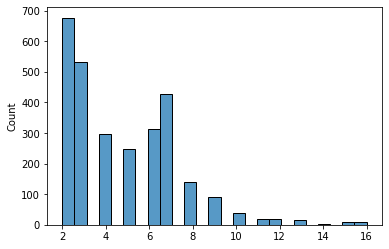

In [11]:
histogram = sns.histplot(list_sum_keywords)
fig = histogram.get_figure()
fig.savefig("query_keywords_distribution.png")

Distribution of keywords present per query is skewed to the right. This means that the number of keywords per query is mostly small but the average is still decent. That, added to the fact that the length range seems also acceptable, leads to the conclusion that the selected training instances are suitable for the project.

## Partition of dataset

We will split the filtered dataframe in separate training and testing datasets (80% training & 20% testing).

In [12]:
y_df = df_filtered["query_toks"].copy()
X_df = df_filtered["question_toks"].copy()

Add start and end symbols to facilitate inference.

In [13]:
for query in y_df:
  # Start
  query[:0] = [r"@"]
  # End
  query.append(r"&")

In [14]:
# Create separate training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, 
                                                    random_state=50)  
# By setting a random_state above, we make sure anytime we run this line we end 
# up with the same train and test sets
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

2268 568
2268 568


## Dataset encoding of tokens

Data will be encoded in "squares" and the dimensions of the cubes will represent the tokens present in each of the two components using a dictionary indexes. The dimensions of each cube will be arranged as follows: num_queries * max_num_tokens.

For example, in our filtered dataframe we have 2836 examples.

#### Training dataset

In [15]:
nl_questions = []
nl_tokens = []
sql_queries = []
sql_tokens = []
max_query_len = 0
max_question_len = 0

# Insert start and end characters to the target dictionary
sql_tokens.append("@")
sql_tokens.append("&")

for index,_ in enumerate(X_train.values.tolist()):
    nl_questions.append(X_train.iloc[index])
    sql_queries.append(y_train.iloc[index])

    # Determine max length of input and output training instances.
    if len(X_train.iloc[index]) > max_question_len:
        max_question_len = len(X_train.iloc[index])
    if len(y_train.iloc[index]) > max_query_len:
        max_query_len = len(y_train.iloc[index])

    # Insert tokens into "dictionary" if not present yet.
    for token_nl in X_train.iloc[index]:
        if token_nl not in nl_tokens:
            nl_tokens.append(token_nl)
    for token_sql in y_train.iloc[index]:
        if token_sql not in sql_tokens:
            sql_tokens.append(token_sql)

# Sort the dictionaries.
sql_tokens = sorted(sql_tokens)
nl_tokens = sorted(nl_tokens)

In [16]:
print("Number of input questions: %d" % len(nl_questions))
print("Number of output sql queries: %d" % len(sql_queries))
num_nl_tokens = len(nl_tokens)
print("Number of question tokens: {}".format(num_nl_tokens))
num_sql_tokens = len(sql_tokens)
print("Number of queries tokens: {}".format(num_sql_tokens))
print("Max length of questions: %d" % max_question_len)
print("Max length of queries: %d" % max_query_len)

Number of input questions: 2268
Number of output sql queries: 2268
Number of question tokens: 1793
Number of queries tokens: 2231
Max length of questions: 43
Max length of queries: 62


In [17]:
# Create proper dictionaries of tokens to improve time complexity of populating 
# dataset squares.
nl_tokens_index = dict()
sql_tokens_index = dict()

for index, token in enumerate(nl_tokens):
    nl_tokens_index[token] = index

for index, token in enumerate(sql_tokens):
    sql_tokens_index[token] = index

In [18]:
# Create square and populate them with the dictionary indexes encoding.
encoder_input_data = np.zeros((len(nl_questions), 
                               max_question_len), dtype="float32")
decoder_input_data = np.zeros((len(nl_questions), 
                               max_query_len), dtype="float32")
decoder_output_data = np.zeros((len(nl_questions), 
                                max_query_len), dtype="float32")

# Iterate through both lists of NL questions and SQL queries.
for i, (question, query) in enumerate(zip(nl_questions, sql_queries)):
    # Iterate through each token of the NL question and mark the corresponding 
    # space in the square with the corresponding dictionary index.
    for j, token in enumerate(question):
        encoder_input_data[i, j] = nl_tokens_index[token]
    # Iterate through each token of the SQL question and follow the same 
    # procedure for both decoders keeping in mind that the output decoder is 
    # goes 1-timestep ahead.
    for j, token in enumerate(query):
        decoder_input_data[i, j] = sql_tokens_index[token]
        if j > 0:
            decoder_output_data[i, j - 1] = sql_tokens_index[token]

print("Number of training instances: %d // Max length of questions: %d" %
      (len(encoder_input_data), len(encoder_input_data[0])))

Number of training instances: 2268 // Max length of questions: 43


In [19]:
print(nl_questions[0])

['How', 'many', 'staff', 'live', 'in', 'state', 'Georgia', '?']


In [20]:
print(np.int32(encoder_input_data[0]))

[ 271 1176 1581 1137 1051 1592  247  131    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In this case, by observing the first three integers of the first three coded sequences and comparing them against the first three tokens of the first three natural language questions, the following word-integer pairings can be observed:
*   "How" -> 271
*   "many" -> 1176
*   "What" -> 440
*   "is" -> 1086



#### Testing dataset

In [21]:
nl_questions_test = []
nl_tokens_test = []
sql_queries_test = []
sql_tokens_test = []
max_query_len_test = 0
max_question_len_test = 0

# Insert start and end characters to the target dictionary
sql_tokens_test.append("@")
sql_tokens_test.append("&")

for index,_ in enumerate(X_test.values.tolist()):
    nl_questions_test.append(X_test.iloc[index])
    sql_queries_test.append(y_test.iloc[index])

    # Determine max length of input and output testing instances.
    if len(X_test.iloc[index]) > max_question_len_test:
        max_question_len_test = len(X_test.iloc[index])
    if len(y_test.iloc[index]) > max_query_len_test:
        max_query_len_test = len(y_test.iloc[index])

    # Insert tokens into "dictionary" if not present yet.
    for token_nl in X_test.iloc[index]:
        if token_nl not in nl_tokens_test:
            nl_tokens_test.append(token_nl)
    for token_sql in y_test.iloc[index]:
        if token_sql not in sql_tokens_test:
            sql_tokens_test.append(token_sql)

# Sort the dictionaries.
sql_tokens_test = sorted(sql_tokens_test)
nl_tokens_test = sorted(nl_tokens_test)

In [22]:
print("Number of input questions testing: %d" % len(nl_questions_test))
print("Number of output sql queries testing: %d" % len(sql_queries_test))
num_nl_tokens_test = len(nl_tokens_test)
print("Number of question tokens testing: {}".format(num_nl_tokens_test))
num_sql_tokens_test = len(sql_tokens_test)
print("Number of queries tokens testing: {}".format(num_sql_tokens_test))
print("Max length of questions testing: %d" % max_question_len_test)
print("Max length of queries testing : %d" % max_query_len_test)

Number of input questions testing: 568
Number of output sql queries testing: 568
Number of question tokens testing: 987
Number of queries tokens testing: 1235
Max length of questions testing: 36
Max length of queries testing : 57


In [23]:
# Create proper dictionaries of tokens to improve time complexity of populating dataset cubes.
nl_tokens_index_test = dict()
sql_tokens_index_test = dict()

for index, token in enumerate(nl_tokens_test):
    nl_tokens_index_test[token] = index

for index, token in enumerate(sql_tokens_test):
    sql_tokens_index_test[token] = index

In [24]:
# Create squares and populate them with dictionary indexes.
encoder_input_test = np.zeros((len(nl_questions_test), 
                               max_question_len_test), dtype="float32")
decoder_input_test = np.zeros((len(sql_queries_test), 
                               max_query_len_test), dtype="float32")
decoder_output_test = np.zeros((len(sql_queries_test), 
                                max_query_len_test), dtype="float32")

# Iterate through both lists of NL questions and SQL queries.
for i, (question, query) in enumerate(zip(nl_questions_test, sql_queries_test)):
    # Iterate through each token of the NL question and mark the corresponding 
    # space in the square with the corresponding dictionary index.
    for j, token in enumerate(question):
        encoder_input_test[i, j] = nl_tokens_index_test[token]
    # Iterate through each token of the SQL question and follow the same 
    # procedure for both decoders keeping in mind that the output decoder is 
    # goes 1-timestep ahead.
    for j, token in enumerate(query):
        decoder_input_test[i, j] = sql_tokens_index_test[token]
        if j > 0:
            decoder_output_test[i, j - 1] = sql_tokens_index_test[token]

print("Number of training instances: %d // Max length of questions: %d" % 
      (len(encoder_input_test), len(encoder_input_test[0])))

Number of training instances: 568 // Max length of questions: 36
